In [29]:

from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin , ClassifierMixin, RegressorMixin

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import GridSearchCV, KFold
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

### fn's

In [30]:
class KappaEncoder(BaseEstimator, TransformerMixin):
    def __init__(self,kappa = 0):
        self.kappa = kappa

    def kappa_impute(self,x_t,x_i,y_i,kappa):
        distances = np.abs(x_t - x_i)
        weights = 1 / ((1 + distances) ** kappa)
        return np.sum(y_i * weights)/np.sum(weights)

    def encode(self, X):
        for col in self.columns:
            unique_vals = np.unique(X[:,col])
            X_train_col_np = self.train_col_values[col]
            for val in unique_vals:
                self.missing_values[(col, val)] = self.kappa_impute(val,X_train_col_np,self.train_target_values,self.kappa[col])
            for val in set(np.unique(X_train_col_np)) - set(unique_vals):
                self.missing_values[(col, val)] = self.missing_values[(col, val)] = self.kappa_impute(val,X_train_col_np,self.train_target_values,self.kappa[col])
        for (col,val), imputed_value in self.missing_values.items():
            X[X[:,col] == val,col] = imputed_value
        return X

    def fit(self,X,y):
        self.columns = list(range(0,X.shape[1]))
        self.missing_values = {}
        self.train_col_values = {col:X[:,col] for col in self.columns}
        self.train_target_values = y

    def transform(self, X , y = None):
        return self.encode(X.copy())

    def fit_transform(self, X , y):
        self.fit(X, y)
        return self.transform(X)




class KappaClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self,kappa = 0):
        self.kappa = kappa

    def fit (self,X,y):
        #add check method
        self.X_train = X
        self.y_train = y
        self.classes_ = np.unique(y)

    def predict(self,X):
        #add check fit method
        d = np.linalg.norm(X[:, None] - self.X_train, axis=2)
        weights = 1 / (1 + d ) ** self.kappa
        c = np.sum(self.y_train * weights, axis=1) / np.sum(weights, axis=1)
        c = np.around(c,decimals=0) #uses a threshold of 0.5 we can be more elegant about this
        return c


    def predict_proba(self,X):
        d = np.linalg.norm(X[:, None] - self.X_train, axis=2)
        weights = 1 / (1 + d ) ** self.kappa
        c = np.sum(self.y_train * weights, axis=1) / np.sum(weights, axis=1)
        c = np.vstack((1-c,c)).T
        return c


### Test

In [31]:
strokeDatasetURL = 'https://raw.githubusercontent.com/JosiahJoeking/Stroke-Dataset/main/healthcare-dataset-stroke-data.csv'
df = pd.read_csv(strokeDatasetURL)

df.drop(columns=['id'], inplace=True)

bmiAVG = df.loc[:, 'bmi'].mean()
df = df.fillna(value = bmiAVG)

df['gender'] = df['gender'].map({'Male': 0, 'Female': 1, 'Other': 2})
df['ever_married'] = df['ever_married'].map({'Yes': 1, 'No': 0})
df['work_type'] = df['work_type'].map({'Private': 0, 'Self-employed': 1, 'Govt_job': 2, 'children': 3, 'Never_worked': 4})
df['Residence_type'] = df['Residence_type'].map({'Urban': 0, 'Rural': 1})
df['smoking_status'] = df['smoking_status'].map({'never smoked': 0, 'smokes': 1, 'formerly smoked': 2, 'Unknown': 3})

### Normal

In [32]:
inputs = df.drop('stroke', axis=1).copy()
target = df['stroke']

X = inputs.values
y = target.values

In [33]:
ke = KappaEncoder([0.0 for a in range(0,X.shape[1])])
kr = KappaClassifier(0.0)

# Define the pipeline with imbalanced-learn's Pipeline
pipeline = ImbPipeline([('enc', ke), ('clf', kr)])

# Define the parameter grid
param_grid = {
    'enc__kappa': [[0.1*a] * X.shape[1] for a in range(0, 20)],
    'clf__kappa': [0.1 * a for a in range(0, 20)]
}

grid_search = GridSearchCV(pipeline,
                                param_grid,
                                cv= KFold(n_splits=5, shuffle=True, random_state=42),
                                scoring= 'roc_auc',
                                n_jobs=5).fit(X,y)

In [34]:
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X)
f1 = f1_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

print("F1 Score:", f1)
print("Accuracy Score:", accuracy)
tn, fp, fn, tp = conf_matrix.ravel()
wicm = (10*fn + fp)/(tn + fp + fn + tp)
print('Weighted incorrect classification metric: {}'.format(wicm))

F1 Score: 0.0
Accuracy Score: 0.9512720156555773
Weighted incorrect classification metric: 0.487279843444227


In [35]:
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.95      1.00      0.98      4861
           1       0.00      0.00      0.00       249

    accuracy                           0.95      5110
   macro avg       0.48      0.50      0.49      5110
weighted avg       0.90      0.95      0.93      5110



c:\Users\josia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\josia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\josia\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

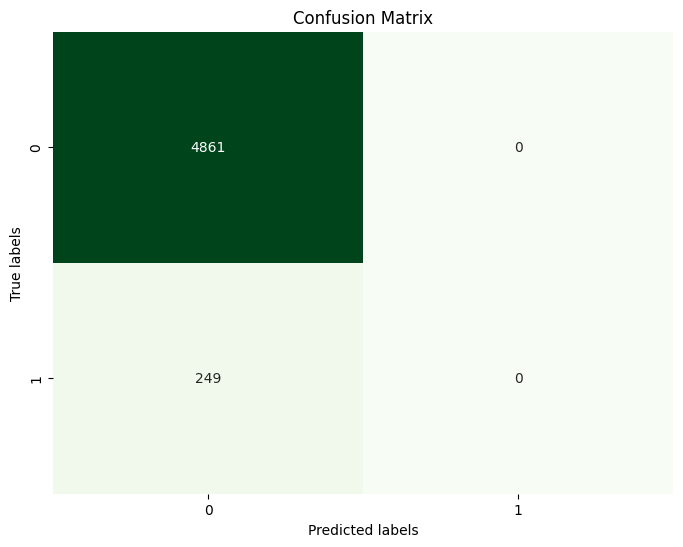

In [36]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [37]:
print(grid_search.best_score_)
print(grid_search.best_params_)
grid_search.best_estimator_

0.8393974505737081
{'clf__kappa': 1.5, 'enc__kappa': [0.6000000000000001, 0.6000000000000001, 0.6000000000000001, 0.6000000000000001, 0.6000000000000001, 0.6000000000000001, 0.6000000000000001, 0.6000000000000001, 0.6000000000000001, 0.6000000000000001]}


Pipeline(steps=[('enc',
                 KappaEncoder(kappa=[0.6000000000000001, 0.6000000000000001,
                                     0.6000000000000001, 0.6000000000000001,
                                     0.6000000000000001, 0.6000000000000001,
                                     0.6000000000000001, 0.6000000000000001,
                                     0.6000000000000001, 0.6000000000000001])),
                ('clf', KappaClassifier(kappa=1.5))])

### Over Sampling

In [38]:
# Define SMOTE with random state
smote = SMOTE(random_state=42)

In [39]:
inputs = df.drop('stroke', axis=1).copy()
target = df['stroke']

X = inputs.values
y = target.values

#X, y = smote.fit_resample(X, y)

In [40]:
ke = KappaEncoder([0.0 for a in range(0,X.shape[1])])
kr = KappaClassifier(0.0)

# Define the pipeline with imbalanced-learn's Pipeline
pipeline = ImbPipeline([('smote', smote), ('enc', ke), ('clf', kr)])

# Define the parameter grid
param_grid = {
    'enc__kappa': [[0.1*a] * X.shape[1] for a in range(0, 20)],
    'clf__kappa': [0.1 * a for a in range(0, 20)]
}

grid_search = GridSearchCV(pipeline,
                                param_grid,
                                cv= KFold(n_splits=5, shuffle=True, random_state=42),
                                scoring= 'roc_auc',
                                n_jobs=5).fit(X,y)

In [41]:
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X)
f1 = f1_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

print("F1 Score:", f1)
print("Accuracy Score:", accuracy)
tn, fp, fn, tp = conf_matrix.ravel()
wicm = (10*fn + fp)/(tn + fp + fn + tp)
print('Weighted incorrect classification metric: {}'.format(wicm))

F1 Score: 0.2115669797330697
Accuracy Score: 0.687866927592955
Weighted incorrect classification metric: 0.37377690802348335


In [42]:
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.68      0.81      4861
           1       0.12      0.86      0.21       249

    accuracy                           0.69      5110
   macro avg       0.56      0.77      0.51      5110
weighted avg       0.95      0.69      0.78      5110



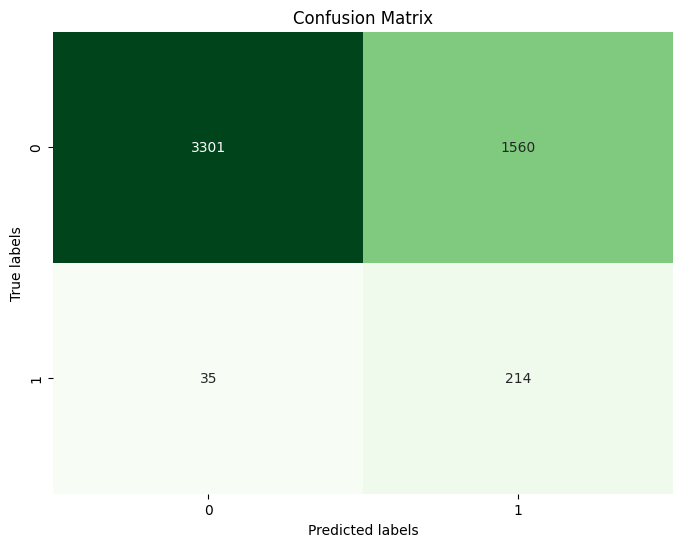

In [43]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [44]:
print(grid_search.best_score_)
print(grid_search.best_params_)
grid_search.best_estimator_

0.8403570200606154
{'clf__kappa': 1.8, 'enc__kappa': [0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9]}


Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('enc',
                 KappaEncoder(kappa=[0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9, 0.9,
                                     0.9, 0.9])),
                ('clf', KappaClassifier(kappa=1.8))])

### Under Sampling

In [45]:
pos = df[df['stroke']==1]
neg = df[df['stroke']==0]

neg = neg.head(pos.shape[0])
df_undersample = pd.concat([pos,neg],axis=0)
df_undersample = shuffle(df_undersample , random_state=42)
df_undersample.reset_index(drop=True, inplace=True)

inputs = df_undersample.drop('stroke', axis=1).copy()
target = df_undersample['stroke']

In [46]:
X = inputs.values
y = target.values

In [47]:
ke = KappaEncoder([0.0 for a in range(0,X.shape[1])])
kr = KappaClassifier(0.0)

# Define the pipeline with imbalanced-learn's Pipeline
pipeline = ImbPipeline([('enc', ke), ('clf', kr)])

# Define the parameter grid
param_grid = {
    'enc__kappa': [[0.1*a] * X.shape[1] for a in range(0, 20)],
    'clf__kappa': [0.1 * a for a in range(0, 20)]
}

grid_search = GridSearchCV(pipeline,
                                param_grid,
                                cv= KFold(n_splits=5, shuffle=True, random_state=42),
                                scoring= 'roc_auc',
                                n_jobs=5).fit(X,y)


In [48]:
best_estimator = grid_search.best_estimator_

y_pred = best_estimator.predict(X)
f1 = f1_score(y, y_pred)
conf_matrix = confusion_matrix(y, y_pred)
accuracy = accuracy_score(y, y_pred)

print("F1 Score:", f1)
print("Accuracy Score:", accuracy)
tn, fp, fn, tp = conf_matrix.ravel()
wicm = (10*fn + fp)/(tn + fp + fn + tp)
print('Weighted incorrect classification metric: {}'.format(wicm))

F1 Score: 0.8150943396226416
Accuracy Score: 0.8032128514056225
Weighted incorrect classification metric: 0.7931726907630522


In [49]:
report = classification_report(y, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.85      0.74      0.79       249
           1       0.77      0.87      0.82       249

    accuracy                           0.80       498
   macro avg       0.81      0.80      0.80       498
weighted avg       0.81      0.80      0.80       498



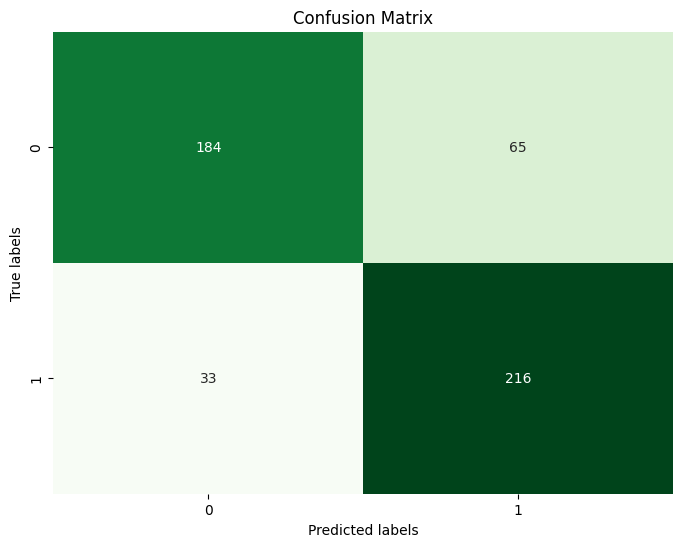

In [50]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [51]:
print(grid_search.best_score_)
print(grid_search.best_params_)
grid_search.best_estimator_

0.8433118625076986
{'clf__kappa': 1.9000000000000001, 'enc__kappa': [1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001, 1.4000000000000001]}


Pipeline(steps=[('enc',
                 KappaEncoder(kappa=[1.4000000000000001, 1.4000000000000001,
                                     1.4000000000000001, 1.4000000000000001,
                                     1.4000000000000001, 1.4000000000000001,
                                     1.4000000000000001, 1.4000000000000001,
                                     1.4000000000000001, 1.4000000000000001])),
                ('clf', KappaClassifier(kappa=1.9000000000000001))])